# Analyze CSV data files with Vanna

world top companies
- https://www.kaggle.com/datasets/patricklford/largest-companies-analysis-worldwide
    -  https://www.kaggle.com/code/nil2012/top-company-key-metrics-analysis

## Setup

In [1]:
from glob import glob
import os
import re
from time import time
from datetime import datetime 

import pandas as pd
import sqlite3

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

In [2]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

### load SQLite db with CSV data

In [3]:
file_db_path = "../data/company_rank.sqlite"
file_db = os.path.abspath(os.path.expanduser(file_db_path))
print(file_db)

/home/gongai/projects/wgong/py4kids/lesson-18-ai/vanna/note_book/data/company_rank.sqlite


In [4]:
LOAD_CSV = True # False
if LOAD_CSV:
    csv_files = glob("../data/company_rank/*.csv")
    print(csv_files)
    
    conn = sqlite3.connect(file_db)
    df_dict = {}
    col_map = {}
    for i in csv_files:
        t = i.split("/")[-1].lower().replace("companies_ranked_by_","").replace(".csv","")
        df = pd.read_csv(i)
        c_map = {c:c.lower() for c in df.columns}
        c_map['price (GBP)'] = 'price_gbp'
        # print(f"col_map: {c_map}")
        table_name = f"t_{t}"
        print(f"\n Loading data from file: '{i}' \n into table_name: '{table_name}'")
        col_map[table_name] = c_map
        df.rename(columns=c_map, inplace=True)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        df_dict[table_name] = df
    conn.close()

['../data/company_rank/Companies_ranked_by_P_E_ratio.csv', '../data/company_rank/Companies_ranked_by_Market_Cap.csv', '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv', '../data/company_rank/Companies_ranked_by_Earnings.csv', '../data/company_rank/Companies_ranked_by_Revenue.csv', '../data/company_rank/country_region.csv']

 Loading data from file: '../data/company_rank/Companies_ranked_by_P_E_ratio.csv' 
 into table_name: 't_p_e_ratio'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Market_Cap.csv' 
 into table_name: 't_market_cap'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv' 
 into table_name: 't_dividend_yield'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Earnings.csv' 
 into table_name: 't_earnings'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Revenue.csv' 
 into table_name: 't_revenue'

 Loading data from file: '../data/company_rank/country_region.csv' 
 into ta

In [5]:
# verify
VERIFY_DB = True # False # 
if VERIFY_DB:
    conn = sqlite3.connect(file_db)
    sql_stmt = f"select name from {table_name} limit 10"
    sql_stmt = """ 
    select country from t_revenue
     UNION 
    select country from t_earnings
     UNION 
    select country from t_market_cap
     UNION 
    select country from t_p_e_ratio
     UNION 
    select country from t_dividend_yield
    """
    df_2 = pd.read_sql_query(sql_stmt, conn).fillna("")
    country_list = df_2["country"].to_list()
    # print(df_2)
    conn.close()

In [6]:
country_list

['',
 'Argentina',
 'Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Belgium',
 'Bermuda',
 'Brazil',
 'British Virgin Islands',
 'Cambodia',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Gibraltar',
 'Greece',
 'Guernsey',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Japan',
 'Jersey',
 'Jordan',
 'Kazakhstan',
 'Kuwait',
 'Lithuania',
 'Luxembourg',
 'Macau',
 'Malaysia',
 'Malta',
 'Mexico',
 'Monaco',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'Norway',
 'Oman',
 'Pakistan',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'South Africa',
 'South Korea',
 'Spain',
 'Sudan',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay'

### Fix country

### Setup LLM

In [7]:
model_name = 'deepseek-coder-v2'
config = {
    'model': model_name,   # 'mistral' # "starcoder2"
}

clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [8]:
vn = MyVanna(config=config)

In [9]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [10]:
# file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [11]:
vn.run_sql_is_set

True

In [12]:
if clean_and_train:
    vn.remove_collections()

## Prepare Training Data

### Add DDL SQL statements

You only need to train once. Do not train again unless you want to add more training data.

In [13]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [14]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\..."
1,table,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,..."
2,table,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE..."
3,table,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n..."
4,table,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ..."
5,table,"CREATE TABLE ""t_country_region"" (\n""country"" T..."


### Add business terms

In [15]:
business_docs = [
"""
Introduction:
This dataset ranks top companies in the world.
Its analysis delves into the financial performance of top companies by examining key metrics such as 
- revenue, 
- earnings, 
- market capitalisation, 
- P/E ratio, 
- dividend yield. 

By comparing these metrics, we gain a comprehensive understanding of a company's scale, 
profitability, market value, and growth potential. 
Through visualisations, the analysis also explores correlations between these metrics and offers 
insights into country-level performance, highlighting economic dominance across various sectors. 
This holistic approach provides a multi-dimensional view of global financial powerhouses, investor confidence, 
and regional economic trends.
""",

"""
Terminologies:
TTM : Trailing Twelve Months
PE : Price over Earning Raio
LOV : List-of-Values
""",

"""
Key Metrics 1. Revenue (TTM):
Table Name: t_revenue ;
Definition: This is the total income generated by a company from its operations in the last twelve months ;
Potential Insights: High revenue often indicates market dominance or high sales volume. Comparing revenues can reveal which companies are the largest in terms of business volume.
""",

"""
Key Metrics 2. Earnings (TTM):
Table Name: t_earnings
Definition: This refers to the company's profit after taxes and expenses over the trailing twelve months.
Potential Insights: Companies with high earnings are more efficient at converting revenue into profit, suggesting better profitability or cost management. A comparison of earnings provides insight into profitability rather than just scale.
""",

"""
Key Metrics 3. Market Capitalisation (Market Cap):
Table Name: t_market_cap
Definition: Market cap is the total value of a company's outstanding shares of stock, calculated as stock price multiplied by the number of shares. It indicates the company’s size in the stock market.
Potential Insights: High market cap usually indicates investor confidence in the company. Comparing market cap among the top 15 companies reveals their relative size in financial markets.
""",

"""
Key Metrics 4. P/E Ratio (TTM):
Table Name: t_p_e_ratio
Definition: Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings.
Potential Insights: A high P/E ratio may indicate that investors expect high growth in the future, while a low P/E ratio could imply undervaluation or scepticism about growth. Companies are compared by their growth prospects or current valuation.
""",

"""
Key Metrics 5. Dividend Yield (TTM):
Table Name: t_dividend_yield
Definition: Dividend yield is a financial ratio that shows how much a company pays out in dividends each year relative to its share price.
Potential Insights: High dividend yield may indicate that a company returns more income to shareholders. It’s particularly useful for income-focused investors.
""",

"""
List-of-Value (LOV) mapping: Country to Region
Table Name: t_country_region
Definition: This table translate country to region, can be used to join on country column with other tables to rollup metrics at region-level
""",
]

In [16]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    # vn.train(documentation="In the chinook database invoice means order")
    for bus_doc in business_docs:
        vn.train(documentation=bus_doc)

Adding ddl: CREATE TABLE "t_p_e_ratio" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "pe_ratio_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_market_cap" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "marketcap" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_dividend_yield" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "dividend_yield_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_earnings" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "earnings_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_revenue" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "revenue_ttm" INTEGER,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_country_region" (
"country" TEXT,
  "region" TEXT,
  "sub_region" TEXT,
  "country_code_2" TEXT,
  "country_code_3" TEXT,
  "note" TEXT
)
Adding documentation....
Adding documentation....
Adding documentation.

In [17]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,051f4399-1594-56de-b0bd-9f74053fd5ff-ddl,None,"CREATE TABLE ""t_country_region"" (\n""country"" T...",ddl
1,75de6b21-b3df-53ea-a36f-9af69e40913b-ddl,None,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ...",ddl
2,87669f00-5543-579a-a95c-fec096be48ed-ddl,None,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE...",ddl
3,b94bb579-73d6-521b-86de-5d5e599bbde5-ddl,None,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,...",ddl
4,e0a92066-0804-52fd-be4e-437ac10622de-ddl,None,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n...",ddl
5,f68c7d4a-806f-55f0-962d-74de7018e372-ddl,None,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\...",ddl
0,160dc6f8-f66d-56f9-bf0d-f924c831f5fd-doc,None,\nTerminologies:\nTTM : Trailing Twelve Months...,documentation
1,29b133c0-6d77-5089-b7f4-d74f133c70d3-doc,None,\nKey Metrics 4. P/E Ratio (TTM):\nTable Name:...,documentation
2,5d1a1060-01ff-5a14-8fb8-6a79f1cbff38-doc,None,\nKey Metrics 2. Earnings (TTM):\nTable Name: ...,documentation
3,5ec048b8-d9ec-56c9-8ea3-bc955617643e-doc,None,\nKey Metrics 3. Market Capitalisation (Market...,documentation


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

In [18]:
ts_start = time()

```sql
SELECT name FROM sqlite_master WHERE type = 'table';
```






# QUESTION :  Can you list all tables in the SQLite database catalog?





Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table'


[( <DataFrame> )]
queried dataframe



,name
0,t_p_e_ratio
1,t_market_cap
2,t_dividend_yield
3,t_earnings
4,t_revenue
5,t_country_region



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assuming df is already defined and contains the results from your query
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'].iloc[0],
        title={"text": "Table Name"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=df['name'])])

fig.update_layout(title_text="List of Tables in the SQLite Database")

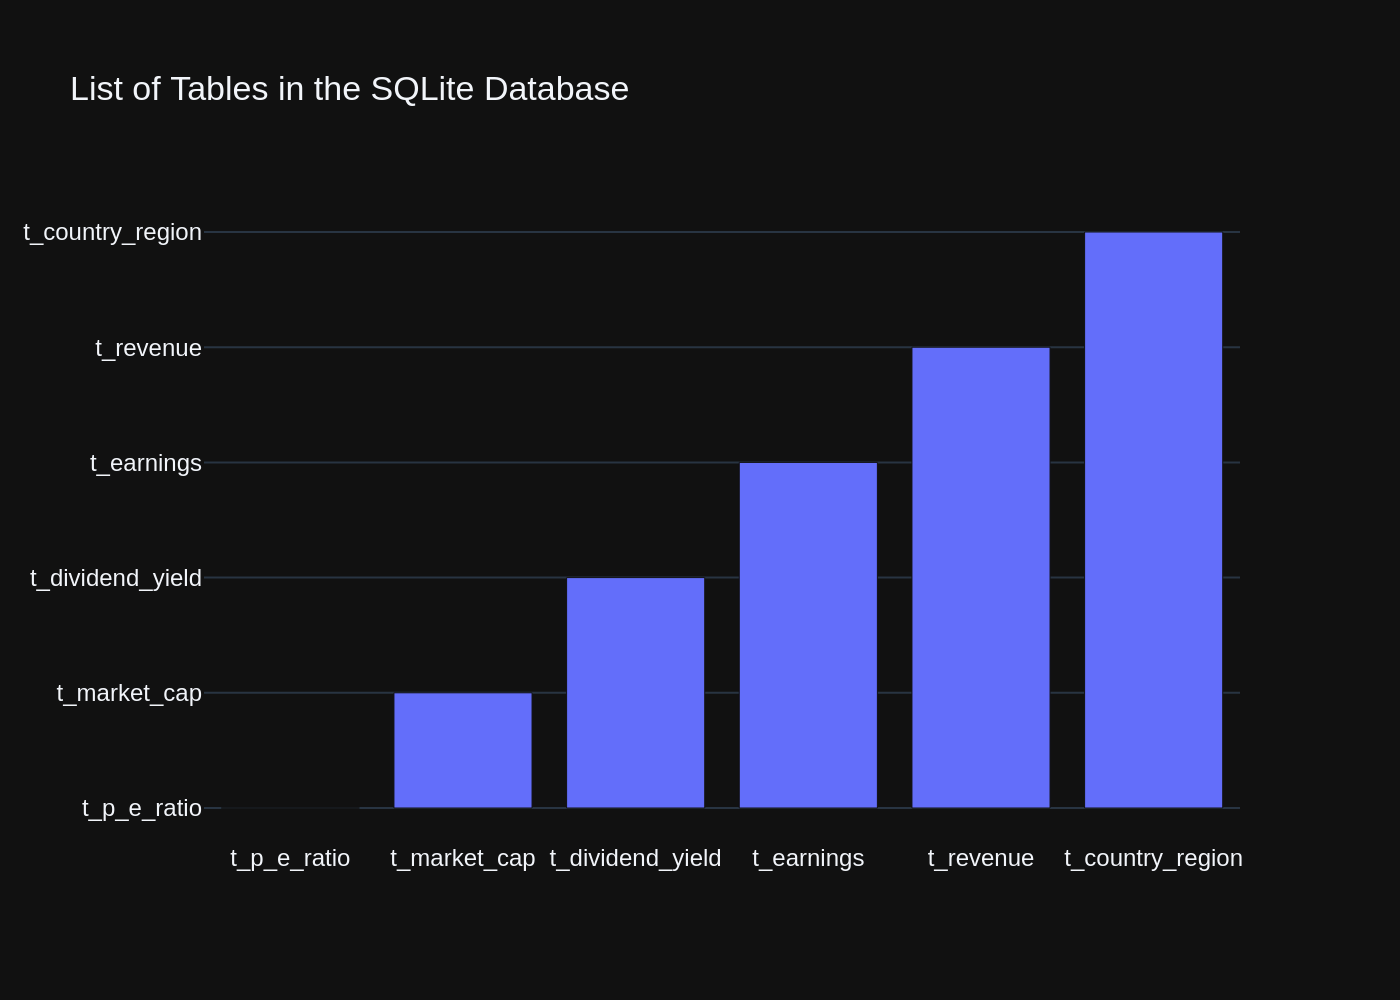

In [19]:
question = "Can you list all tables in the SQLite database catalog?"
resp = vn.ask_adaptive(question=question)

In [20]:
BREAK_HERE = True
if BREAK_HERE:
    raise Exception("Take a break")

Exception: Take a break

In [ ]:
questions = [
"Can you list all tables in the SQLite database catalog?",

"which table stores Company P/E Ratio, Hint: No need to generate SQL",

"which table stores Company Dividend Yield, Hint: No need to generate SQL",

"which table stores Company Market Cap, Hint: No need to generate SQL",

"which table stores Company Revenue, Hint: No need to generate SQL",

"which table stores Company Earnings",

"Find 10 companyies with the lowest PE Ratio above 10 in Germany",   

"Find top 10 companyies in the United States with the heighest market cap",

"Find the customer with the most invoices ",  # negative test

"""
Find top 5 companyies in Asia with the hightes PE Ratio above 40, list company name and PE ratio,
Hint: "Asia" is a region name, you need to join "t_p_e_ratio" table with "t_country_region" table 
on "country" columns to answer this question .
""",

"""
Find top 5 companyies with the lowest PE Ratio in the range of 20-30, list their names and respective PE ratios,
""",

""" 
"What are the Top 20 companies in the United States ranked by Dividend Yield"
""",

""" 
"What are the Top 20 companies in the United States ranked by Revenue"
""",

"""
Find Top 10 Company by Dividend Yield in each country
""",


]

In [ ]:
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)

### Check completion time

In [ ]:
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"Completed tests:\n================\n run on host '{hostname}' \n with LLM model '{model_name}' \n took {elapsed_time:.2f} sec")